# Построение базовой модели рекомендательной системы

In [79]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
import pickle
import random
import math
from sklearn.metrics.pairwise import cosine_similarity

## Подготовка данных

In [80]:
random.seed(3214)

загружаем датасет и словарь с мета-информацией

In [81]:
with open('../data/pickles/main_dict.pickle', 'rb') as f:
    main_dict = pickle.load(f)

In [82]:
df_train = pd.read_csv('../data/csv/train_2.csv', index_col=0)
df_test = pd.read_csv('../data/csv/test_2.csv', index_col=0)

In [83]:
df_train = df_train.drop(df_train.columns[1:553], axis=1)
df_test = df_test.drop(df_test.columns[1:553], axis=1)

In [84]:
df_test

,file,average_loudness,dynamic_complexity,beats_count,bpm,onset_rate,danceability,chords_changes,chords_number,mfcc1_mean.8,...,pitch_salience.min.8,pitch_salience.std.8,chords.max.8,chords.mean.8,chords.min.8,chords.std.8,hpcp.max.8,hpcp.mean.8,hpcp.min.8,hpcp.std.8
0,000190.mp3,0.897391,3.916271,49,100.530136,3.697116,1.060290,0.041667,0.018519,-708.770752,...,0.218740,0.105116,0.699582,0.531642,0.336809,0.082087,35.851597,20.673479,3.277871,8.452773
1,000194.mp3,0.755660,5.867540,46,84.368858,2.697896,0.941967,0.038580,0.015432,-731.174316,...,0.306557,0.097109,0.758795,0.498175,0.299510,0.094081,35.864922,17.619751,3.607089,7.747941
2,000667.mp3,0.987179,1.101408,43,88.428818,4.601753,2.182179,0.030912,0.006182,-650.118347,...,0.228297,0.086061,0.678742,0.517647,0.287426,0.083100,35.722652,10.854980,3.169126,5.265570
3,001040.mp3,0.975220,1.250471,56,123.593201,3.868140,1.137121,0.129830,0.017002,-576.920349,...,0.198499,0.118034,0.692115,0.444388,0.283190,0.068971,35.147663,10.454682,2.464400,5.436674
4,003720.mp3,0.974738,1.007307,55,111.021004,1.533918,0.936378,0.032457,0.007728,-665.626953,...,0.235741,0.097590,0.697874,0.583348,0.388007,0.058415,35.853703,13.515177,3.402863,7.011743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,001686.mp3,0.974597,2.110674,58,118.429314,7.236090,1.876833,0.041731,0.004637,-653.547119,...,0.105094,0.121080,0.801286,0.576270,0.340960,0.093195,35.845860,15.940372,3.966340,7.548143
93,004233.mp3,0.664345,6.897217,60,148.840683,4.729644,1.302297,0.155864,0.026235,-817.844116,...,0.069573,0.145899,0.807500,0.460526,0.222727,0.130176,35.866604,14.923994,2.656023,8.222849
94,027454.mp3,0.983987,1.799070,63,128.594666,3.397350,1.987833,0.067901,0.009259,-689.432739,...,0.062857,0.154675,0.611856,0.448038,0.256524,0.072210,35.774693,15.391316,4.016396,7.682673
95,040851.mp3,0.768085,2.236127,59,120.488045,6.435785,1.131625,0.182380,0.021638,-607.489563,...,0.113288,0.163129,0.720382,0.442133,0.227727,0.105792,32.518559,8.855456,2.723202,4.500797


## Визуализация данных

In [85]:
features_train = df_train.drop(['file'], 1)
features_test = df_test.drop(['file'], 1)

In [86]:
scaler = StandardScaler()
scaler.fit(features_train)
X_train = scaler.transform(features_train)
X_test = scaler.transform(features_test)

In [87]:
pca_viz = PCA(n_components=2)
pca_viz.fit(X_train)
X_train_viz = pca_viz.transform(X_train)
X_test_viz = pca_viz.transform(X_test)

In [88]:
pca_viz.explained_variance_ratio_

array([0.22273628, 0.16663001])

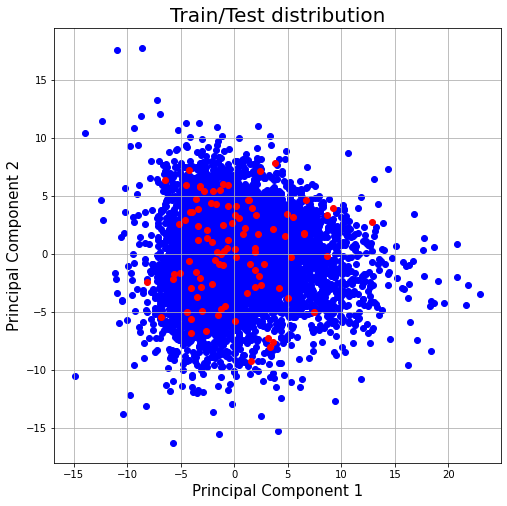

In [89]:
fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Train/Test distribution', fontsize = 20)

ax.scatter(X_train_viz[:, 0], X_train_viz[:, 1], c='b')
ax.scatter(X_test_viz[:, 0], X_test_viz[:, 1], c='r')
ax.grid()

In [101]:
pca_viz_3 = PCA(n_components=3)
pca_viz_3.fit(X_train)
X_train_viz = pca_viz_3.transform(X_train)
X_test_viz = pca_viz_3.transform(X_test)

In [102]:
pca_viz_3.explained_variance_ratio_

array([0.22273065, 0.1666396 , 0.0849208 ])

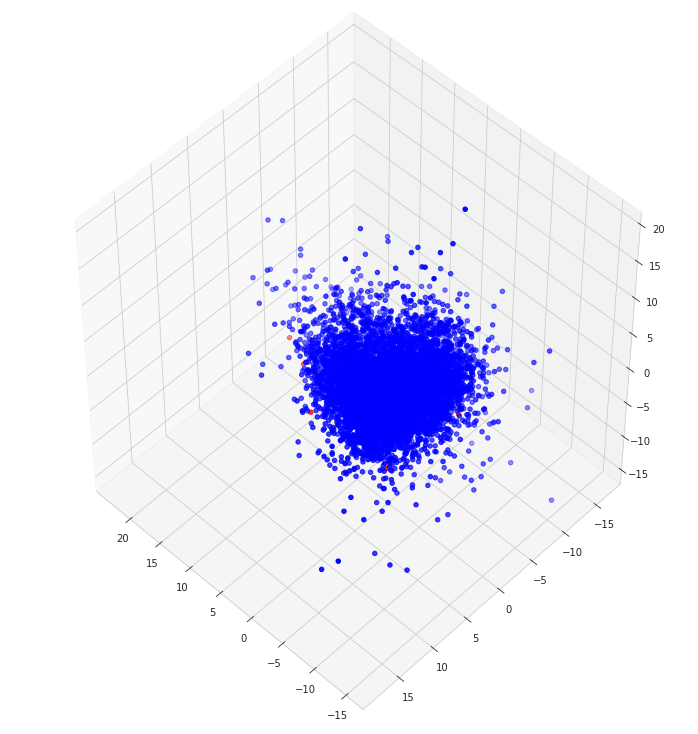

In [104]:
fig = plt.figure(1, figsize=(10, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X_train_viz[:, 0], X_train_viz[:, 1], X_train_viz[:, 2], c='b')
ax.scatter(X_test_viz[:, 0], X_test_viz[:, 1], X_test[:, 2], c='r')


## Формирование векторного пространства

Уменьшим размерность векторов треков методом главных компонент

In [14]:
# pca = PCA(0.95)
# pca.fit(X_train)
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

In [90]:
X_train.shape

(7885, 77)

In [91]:
X_test.shape

(97, 77)

In [92]:
X_test[0]

array([ 0.06979637,  0.52601898, -0.80631459, -0.75926598, -0.04195972,
       -0.59933144, -0.60169571,  1.27708081, -0.14848433, -0.23243048,
       -0.99666797, -0.67435253, -1.30179726, -1.328484  , -2.35290491,
       -1.12222916, -1.8309918 , -0.86417501, -1.53141878, -1.38096034,
       -0.90095057,  0.40893213, -0.19050452,  0.3419127 , -0.09991988,
       -0.4109096 , -0.28381569, -0.37352659, -0.39953036, -0.54596273,
       -0.27244542, -0.3714909 , -0.48234999,  0.18584689, -0.32010179,
        0.63634152, -0.06302467,  0.87797498, -0.01853728,  0.20158378,
        0.15232158, -0.5745501 , -1.18879134, -0.83310732, -0.45341727,
       -1.01745063, -0.54807209, -0.3489019 , -0.72628358,  0.19848726,
       -0.1742843 ,  0.2931162 , -0.24071153,  0.68269674, -0.04911006,
       -0.40294916,  0.18821698,  0.28176765, -0.30200203,  0.42614254,
       -0.01711014, -1.08085113, -0.52486085, -0.38543359, -0.83294555,
        0.91090212,  0.29193327,  0.78254319, -0.54386412, -0.09

In [93]:
# pca.explained_variance_ratio_

Оценим косинусное расстояние между треками

In [94]:
# neigh = NearestNeighbors(10)
# neigh.fit(X_train)

In [95]:
cos_similarity_mtx = cosine_similarity(X_test, X_train)

## Построение рекомендаций и их оценка

В качестве рекомендаций будем использовать 10 ближайших соседей к вектору тестового трека. Для каждой рекомендации будем сравнивать теги с тегами "запроса". Для количественной оценки сходства множества тегов используем f-меру. Если она выше парогового значения, то считаем рекомендацию релевантной. Для количественной оценки релевантности рекомендаций используем prcision@10.Для оценки ранжирования применим nDCG. Для общей оценки рекомендательной системы усредним метрики по всем тестовым запросам.

In [96]:
def count_good_recommend(query_idx, answer_list, trhold):
    counter = 0
    query_id = int(df_test.iloc[query_idx].file[:-4])
    relevant = [query_id]
    query_tags = main_dict[query_id]['all_tags']
    for idx in answer_list:
        answer_id = int(df_train.iloc[idx].file[:-4])
        answer_tags = main_dict[answer_id]['all_tags']
        score = 0
        i = 0
        for tag in answer_tags:
            if tag in query_tags:
                i += 1
        if i == 0:
            continue
        
        precision = i / len(answer_tags)
        recall = i / len(query_tags)
        score = 2 * precision * recall / (precision + recall)
        if score >= trhold:        
            counter += 1
            relevant.append(answer_id)
    return counter, relevant

In [97]:
def count_ndcg(neighbors, relevant_list):
    dcg = 0
    idcg = 0
    for i in range(len(neighbors)):
        track = int(df_train.iloc[neighbors[i]].file[:-4])
        if track in relevant_list:
            dcg += 1 / math.log(i + 2, 2)
        idcg += 1 / math.log(i + 2, 2)
    ndcg = dcg / idcg
    return ndcg

In [98]:
mean_ap = 0
ndcg = 0
for i in range(97):
    arr = cos_similarity_mtx[i]
    neighbors = arr.argsort()[-10:][::-1]
    relevant_num, relevant_list = count_good_recommend(i, neighbors, trhold=0.4)
#     print(relevant_list)
#     print(relevant_list[0], [df_train.iloc[x].file[:-4] for x in neighbors])
    p_at_10 = relevant_num / 10
    mean_ap += p_at_10
    ndcg += count_ndcg(neighbors, relevant_list[1:])
mean_ap /= 97 
mean_ndcg = ndcg / 97

In [99]:
mean_ap

0.10927835051546389

In [100]:
mean_ndcg

0.12083323326399577

In [77]:
df_train[df_train['file']=='000005.mp3']

,file,average_loudness,dynamic_complexity,beats_count,bpm,onset_rate,danceability,chords_changes,chords_number,mfcc1_mean.8,...,pitch_salience.min.8,pitch_salience.std.8,chords.max.8,chords.mean.8,chords.min.8,chords.std.8,hpcp.max.8,hpcp.mean.8,hpcp.min.8,hpcp.std.8
7901,000005.mp3,0.978495,2.676458,50,100.256378,4.563107,1.652637,0.121914,0.012346,-645.724915,...,0.070376,0.152327,0.584055,0.460291,0.258581,0.065509,35.706932,13.278655,3.52222,5.650068


# Черновик

In [109]:
base = list()
mean_ap = 0
ndcg = 0
for i in range(97):
    arr = cos_similarity_mtx[i]
    neighbors = arr.argsort()[-10:][::-1]
    relevant_num, relevant_list = count_good_recommend(i, neighbors, trhold=0.4)
#     print(relevant_list)
#     print(relevant_list[0], [df_train.iloc[x].file[:-4] for x in neighbors])
    p_at_10 = relevant_num / 10
    base.append(p_at_10)
#     mean_ap += p_at_10
#     ndcg += count_ndcg(neighbors, relevant_list[1:])
# mean_ap /= 100 
# mean_ndcg = ndcg / 100

In [103]:
df_train = pd.read_csv('../data/csv/train_embd.csv')
df_test = pd.read_csv('../data/csv/test_embd.csv')

In [104]:
X_train = df_train.drop(columns=['id']).values
X_test = df_test.drop(columns=['id']).values

In [105]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [106]:
def count_good_recommend(query_idx, answer_list, trhold):
    counter = 0
    query_id = int(df_test.iloc[query_idx].id)
    relevant = [query_id]
    query_tags = main_dict[query_id]['all_tags']
    for idx in answer_list:
        answer_id = int(df_train.iloc[idx].id)
        answer_tags = main_dict[answer_id]['all_tags']
        score = 0
        i = 0
        for tag in answer_tags:
            if tag in query_tags:
                i += 1
        if i == 0:
            continue
        
        precision = i / len(answer_tags)
        recall = i / len(query_tags)
        score = 2 * precision * recall / (precision + recall)
        if score >= trhold:        
            counter += 1
            relevant.append(answer_id)
    return counter, relevant

def count_ndcg(neighbors, relevant_list):
    dcg = 0
    idcg = 0
    for i in range(len(neighbors)):
        track = int(df_train.iloc[neighbors[i]].id)
        if track in relevant_list:
            dcg += 1 / np.log2(i + 2)
        idcg += 1 / np.log2(i + 2)
    ndcg = dcg / idcg
    return ndcg



In [107]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=10, metric='euclidean')
neigh.fit(X_train)

NearestNeighbors(metric='euclidean', n_neighbors=10)

In [110]:
cnn = list()
for i in range(97):
    neighbors = neigh.kneighbors([X_test[i]])[1][0]
    
    relevant_num, relevant_list = count_good_recommend(i, neighbors, trhold=0.4)
#     print(relevant_list)
#     print(relevant_list[0], [df_train.iloc[x].file[:-4] for x in neighbors])
    p_at_10 = relevant_num / 10
    cnn.append(p_at_10)

In [28]:
rand = list()
ap = 0
ndcg = 0
# for i in range(100):
#     mean_ap = 0
#     ndcg = 0
for i in range(100):
    test_track = df_test.iloc[i].file
    test_track_genre = main_dict[int(test_track[:-4])]['genre']
    genre_recommendations = list()
    while len(genre_recommendations) < 10:
        idx = random.randint(0, df_train.shape[0] - 1)
        track = df_train.iloc[idx].file
        track_genre = main_dict[int(track[:-4])]['genre']
        if track_genre == test_track_genre:
            genre_recommendations.append(idx)
#     print(i)

    relevant_num, relevant_list = count_good_recommend(i, genre_recommendations, trhold=0.4)
#     print(test_track, relevant_list)
    p_at_10 = relevant_num / 10
    rand.append(p_at_10)
    mean_ap += p_at_10
    ndcg += count_ndcg(genre_recommendations, relevant_list[1:])
mean_ap /= 100 
mean_ndcg = ndcg / 100
# ap += mean_ap
# ndcg += mean_ndcg
print(mean_ap, mean_ndcg)

0.05899999999999998 0.061964319787577465


In [111]:
len(cnn)

97

In [116]:
for i in zip(base,cnn):
    print(i)

(0.2, 0.4)
(0.2, 0.1)
(0.1, 0.1)
(0.0, 0.3)
(0.0, 0.0)
(0.1, 0.1)
(0.0, 0.1)
(0.1, 0.2)
(0.0, 0.5)
(0.0, 0.0)
(0.1, 0.1)
(0.1, 0.4)
(0.1, 0.2)
(0.0, 0.0)
(0.3, 0.5)
(0.0, 0.0)
(0.0, 0.0)
(0.1, 0.2)
(0.0, 0.2)
(0.1, 0.2)
(0.0, 0.1)
(0.1, 0.0)
(0.3, 0.2)
(0.0, 0.1)
(0.0, 0.0)
(0.2, 0.1)
(0.0, 0.0)
(0.4, 0.3)
(0.3, 0.4)
(0.0, 0.0)
(0.0, 0.3)
(0.0, 0.5)
(0.1, 0.2)
(0.0, 0.1)
(0.0, 0.1)
(0.0, 0.2)
(0.0, 0.4)
(0.0, 0.1)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.2, 0.6)
(0.0, 0.0)
(0.0, 0.3)
(0.0, 0.1)
(0.0, 0.0)
(0.1, 0.2)
(0.3, 0.1)
(0.0, 0.2)
(0.0, 0.3)
(0.1, 0.3)
(0.0, 0.4)
(0.0, 0.0)
(0.0, 0.1)
(0.0, 0.1)
(0.0, 0.0)
(0.0, 0.1)
(0.1, 0.2)
(0.0, 0.0)
(0.1, 0.2)
(0.0, 0.1)
(0.0, 0.0)
(0.0, 0.1)
(0.0, 0.0)
(0.4, 0.6)
(0.0, 0.1)
(0.0, 0.4)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.1)
(0.2, 0.5)
(0.0, 0.0)
(0.0, 0.2)
(0.0, 0.0)
(0.1, 0.1)
(0.0, 0.0)
(0.0, 0.1)
(0.0, 0.3)
(0.0, 0.2)
(0.2, 0.3)
(0.0, 0.0)
(0.1, 0.3)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.1)
(0.0, 0.0)
(0.1, 0.4)
(0.2, 0.0)
(0.0, 0.0)

In [112]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
import seaborn as sns
import numpy as np

In [113]:
ttest_ind(base, cnn)

Ttest_indResult(statistic=-4.858361369067862, pvalue=2.4511232220511785e-06)

In [114]:
mannwhitneyu(base, cnn)

MannwhitneyuResult(statistic=3029.5, pvalue=1.3961814673169702e-06)

In [117]:
shapiro(base)

ShapiroResult(statistic=0.6178115606307983, pvalue=1.621803142086084e-14)

In [118]:
shapiro(cnn)

ShapiroResult(statistic=0.8315197229385376, pvalue=3.866350795078688e-09)

In [119]:
import seaborn as sns

In [120]:
data = pd.DataFrame({'Baseline': base, 'CNN': cnn})

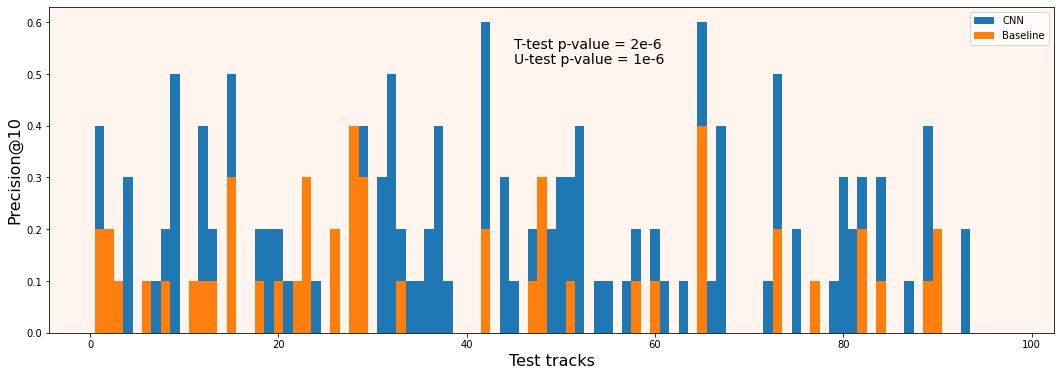

In [129]:
x = range(1,98)
y1 = cnn
y2 = base
fig, ax = plt.subplots()
ax.bar(x, y1, width=1)
ax.bar(x, y2, width=1)
ax.text(45, 0.55,'T-test p-value = 2e-6', fontsize=14)
ax.text(45, 0.52,'U-test p-value = 1e-6', fontsize=14)

ax.set_facecolor('seashell')
# fig.set_facecolor('floralwhite')
fig.set_figwidth(18)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
plt.xlabel('Test tracks', fontsize=16)
plt.ylabel('Precision@10', fontsize=16)
plt.legend(['CNN', 'Baseline'])
plt.show()
# plt.bar(, base)

In [143]:
df_viz

,track,pca-one,pca-two,pca-three,genres,color,tsne-2d-one,tsne-2d-two
0,113360,5.339645,-2.997960,-3.131148,Folk,green,-6.220930,2.543855
1,113564,0.203005,0.101333,0.953855,Experimental,brown,-0.521890,-0.361869
2,113950,3.174741,-1.853430,-1.819284,Folk,green,-5.062304,1.902166
3,113267,-2.759523,2.697860,0.180916,International,pink,3.413563,-4.534875
4,113261,-3.888778,-1.861918,-0.500297,International,pink,4.804661,3.361747
...,...,...,...,...,...,...,...,...
95,001040,-4.627000,2.936739,2.403531,test,black,5.620337,-4.708129
96,001686,-0.559919,1.180454,-0.122616,test,black,0.842412,-2.121464
97,004079,-3.402019,2.400107,0.100905,test,black,4.836450,-2.844817
98,004835,-1.028659,-1.016227,-2.788778,test,black,0.328849,1.692046


In [95]:
main_dict[113360]

{'artist_name': 'Samuel Vas Y',
 'track_title': 'My Head Of Curls',
 'artist_tags': [],
 'track_tags': [],
 'similar_tracks': [],
 'similar_list': [],
 'all_tags': ['folk', 'singer-songwriter'],
 'genre': 'Folk',
 'all_genres': ['Folk', 'Singer-Songwriter']}

In [176]:
genres = [main_dict[int(x[:-4])]['genre'] for x in df_train.file.values]
genres2 = [main_dict[int(x[:-4])]['genre'] for x in df_test.file.values]

In [177]:
df_viz = pd.DataFrame()
df_viz['track'] = [x[:-4] for x in df_train.file.values]
df_viz['pca-one'] = X_train_viz[:, 0]
df_viz['pca-two'] = X_train_viz[:, 1]
df_viz['pca-three'] = X_train_viz[:, 2]
df_viz['genres'] = genres

In [178]:
df_viz2 = pd.DataFrame()
df_viz2['track'] = [x[:-4] for x in df_test.file.values]
df_viz2['pca-one'] = X_test_viz[:, 0]
df_viz2['pca-two'] = X_test_viz[:, 1]
df_viz2['pca-three'] = X_test_viz[:, 2]
df_viz2['genres'] = genres2

In [179]:
df_viz = pd.concat([df_viz, df_viz2], 0)

In [180]:
df_viz['color'] = [my_palette[x] for x in df_viz.genres.values]

In [181]:
df_viz

,track,pca-one,pca-two,pca-three,genres,color
0,113360,5.339645,-2.997960,-3.131148,Folk,green
1,113564,0.203005,0.101333,0.953855,Experimental,brown
2,113950,3.174741,-1.853430,-1.819284,Folk,green
3,113267,-2.759523,2.697860,0.180916,International,pink
4,113261,-3.888778,-1.861918,-0.500297,International,pink
...,...,...,...,...,...,...
95,001040,-4.627000,2.936739,2.403531,Rock,green
96,001686,-0.559919,1.180454,-0.122616,International,pink
97,004079,-3.402019,2.400107,0.100905,International,pink
98,004835,-1.028659,-1.016227,-2.788778,Rock,green


In [124]:
df_viz.genres.unique()

array(['Folk', 'Experimental', 'International', 'Instrumental', 'Hip-Hop',
       'Rock', 'Pop', 'Electronic', 'test'], dtype=object)

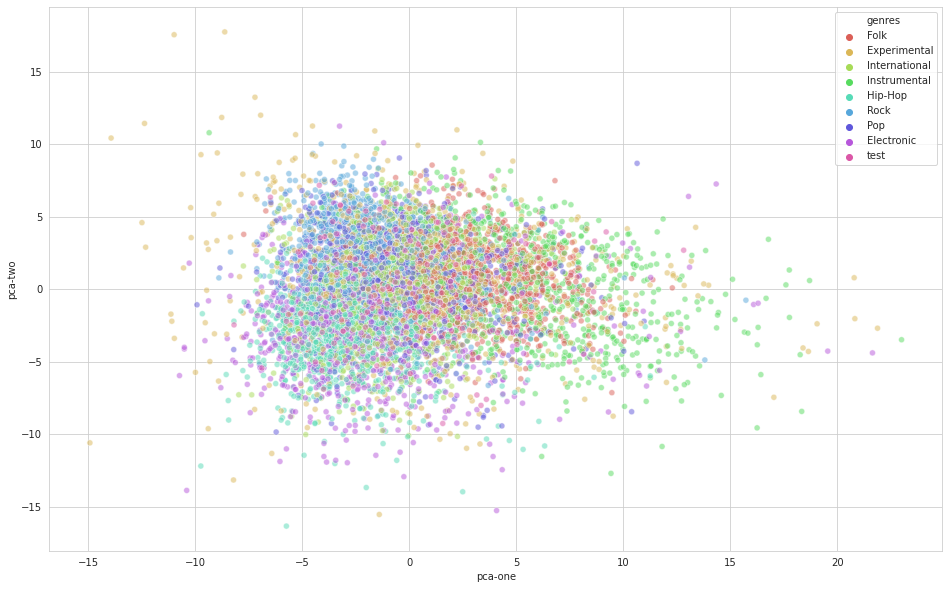

In [149]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="genres",
    palette=sns.color_palette("hls", 9),
    data=df_viz,
    legend="full",
    alpha=0.5
)


In [131]:
my_palette = {
    'Rock': 'green',
    'Pop': 'red',
    'Hip-Hop': 'blue',
    'Folk': 'green',
    'Experimental': 'brown',
    'Instrumental': 'yellow',
    'Electronic': 'orange',
    'International': 'pink',
    'test': 'black'
}

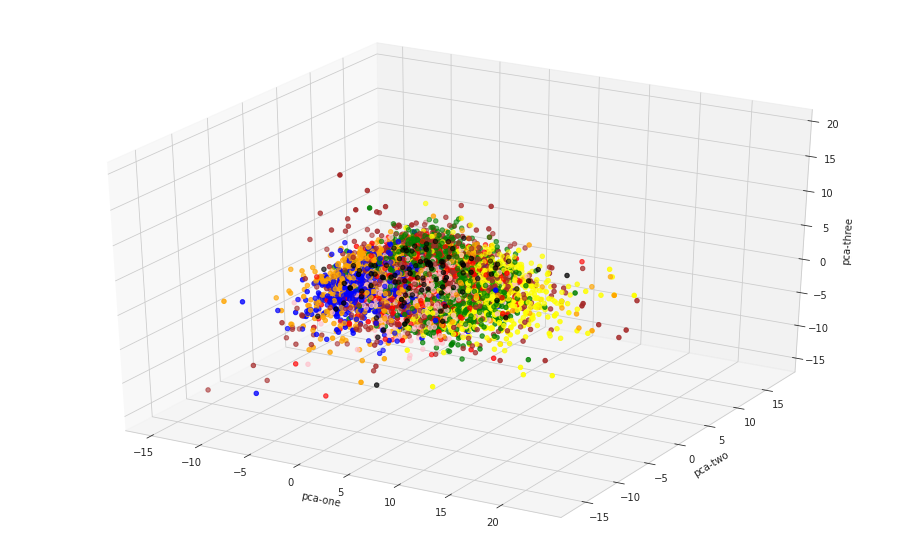

In [134]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df_viz["pca-one"], 
    ys=df_viz["pca-two"], 
    zs=df_viz["pca-three"], 
    c=df_viz["color"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()


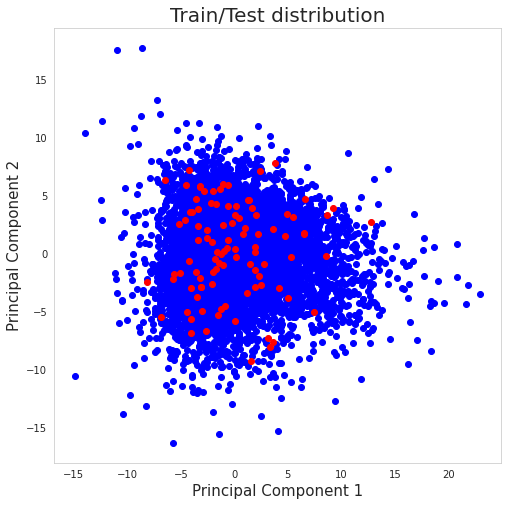

In [79]:
fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Train/Test distribution', fontsize = 20)

ax.scatter(X_train_viz[:, 0], X_train_viz[:, 1], c='b')
ax.scatter(X_test_viz[:, 0], X_test_viz[:, 1], c='r')
ax.grid()

In [135]:
from sklearn.manifold import TSNE

In [139]:
X = np.vstack([X_train, X_test])

In [173]:
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(X)

In [182]:
df_viz['tsne-one'] = tsne_results[:,0]
df_viz['tsne-two'] = tsne_results[:,1]
# df_viz['tsne-three'] = tsne_results[:,2]

In [193]:
df_viz[df_viz.genres.isin(['Hip-Hop', 'Rock'])]

,track,pca-one,pca-two,pca-three,genres,color,tsne-one,tsne-two
9,113037,-0.246673,-5.242860,-5.177208,Hip-Hop,blue,-5.319466,-3.832551
12,113294,-7.008246,3.105488,-2.842263,Rock,green,-6.421494,-7.754514
14,113165,-1.879554,4.837612,0.508407,Rock,green,6.571736,2.754868
15,113063,-2.470953,2.369969,3.565876,Rock,green,5.759766,0.827193
18,113035,-3.696400,-6.131615,-2.082378,Hip-Hop,blue,0.080101,-7.872029
...,...,...,...,...,...,...,...,...
84,063470,-3.213148,5.791115,1.157849,Rock,green,6.695178,2.819943
90,127720,-3.397653,3.830853,1.839367,Rock,green,6.607674,1.588203
93,062337,0.121064,4.116812,3.952454,Rock,green,5.339825,6.722618
95,001040,-4.627000,2.936739,2.403531,Rock,green,7.141715,0.487097


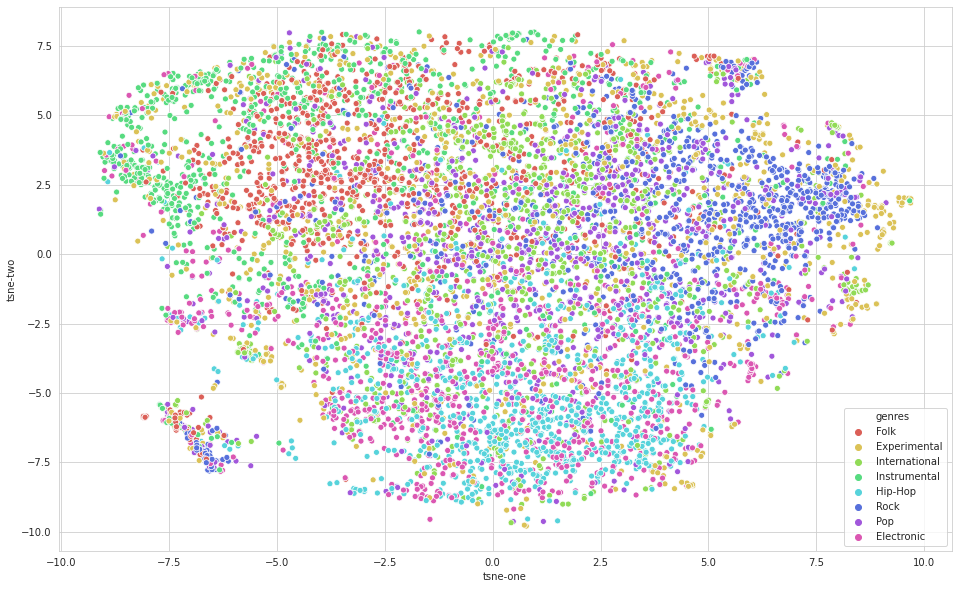

In [218]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="genres",
    palette=sns.color_palette("hls", 8),
    data=df_viz,
    legend="full",
    alpha=1
)

In [236]:
from sklearn.model_selection import GridSearchCV

In [237]:
tsne = TSNE()

In [238]:
params = {
    'perplexity': range(5, 51, 5),
    'learning_rate': [10, 100, 200, 300, 500, 1000]
}

In [241]:
gs = GridSearchCV(estimator=tsne, cv=5, param_grid=params)

In [243]:
gs.fit(X)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=2, n_iter=1000, n_iter_without_progress=300, n_jobs=None,
     perplexity=30.0, random_state=None, verbose=0) does not.

In [ ]:
tsne = TSNE(n_components=3, verbose=0, perplexity=5, learning_rate=10)
tsne_results = tsne.fit_transform(X)

In [246]:
df_viz['tsne-one'] = tsne_results[:,0]
df_viz['tsne-two'] = tsne_results[:,1]
df_viz['tsne-three'] = tsne_results[:,2]

In [247]:
sub = df_viz[df_viz.genres.isin(['Electronic', 'Hip-Hop', 'Rock', 'Instrumental', 'Folk'])]

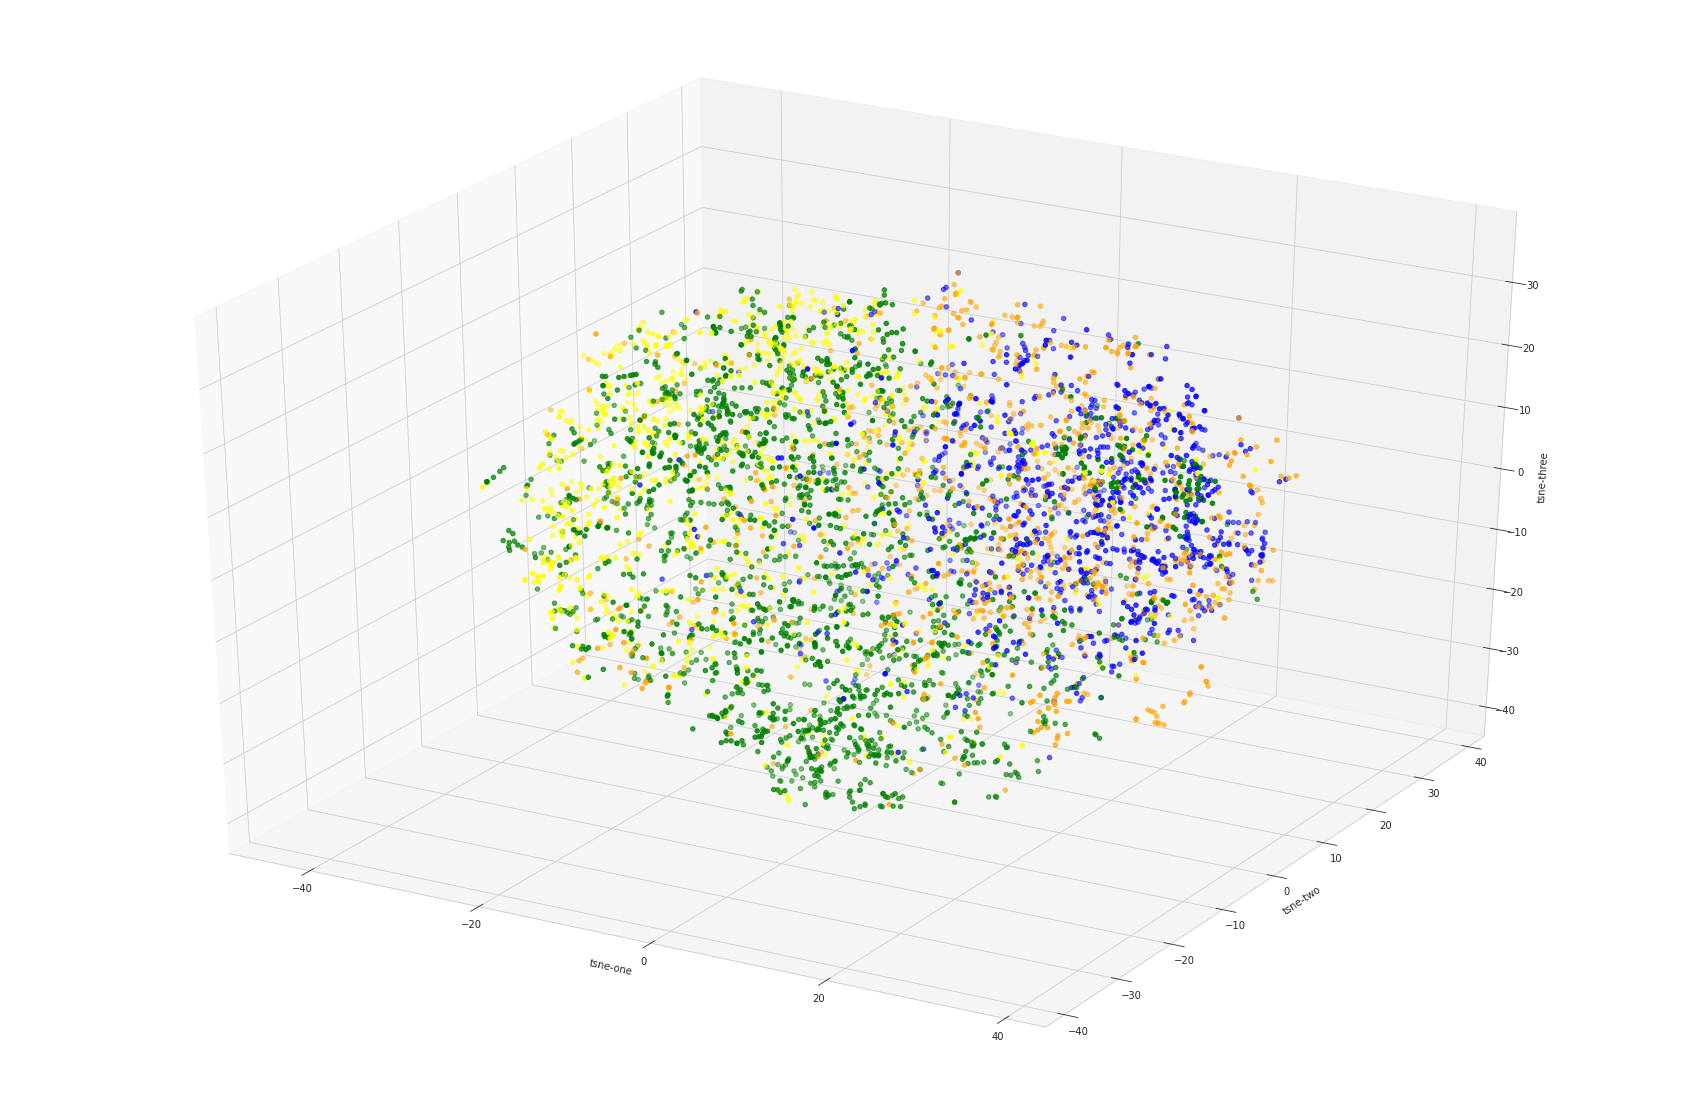

In [248]:
ax = plt.figure(figsize=(30,20)).gca(projection='3d')
ax.scatter(
    xs=sub["tsne-one"], 
    ys=sub["tsne-two"], 
    zs=sub["tsne-three"], 
    c=sub["color"], 
    cmap='tab10'
)
ax.set_xlabel('tsne-one')
ax.set_ylabel('tsne-two')
ax.set_zlabel('tsne-three')
plt.show()


In [249]:
import plotly.express as px

In [250]:
fig = px.scatter_3d(sub, x='tsne-one', y='tsne-two', z='tsne-three',
              color='genres', width=1000, height=1000)
fig.show()

Text(0.7, 0.55, 'p-value = 0.004')

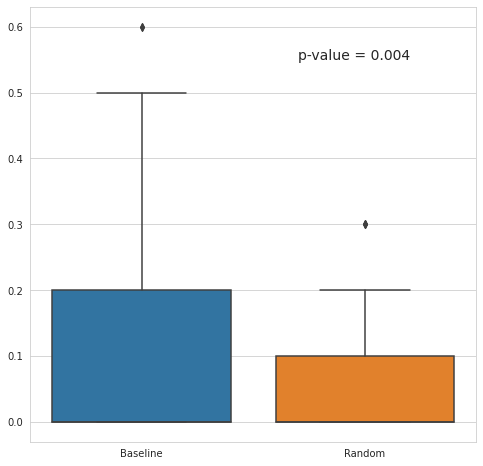

In [37]:
fig = plt.figure(figsize = (8,8))
sns.set_style("whitegrid")
ax = sns.boxplot(data = data)
ax.text(0.7, 0.55,'p-value = 0.004', fontsize=14)


In [234]:
answers = neigh.kneighbors([X_test[42]])[1][0]
answers

array([2842, 5045, 3408, 3140, 2073, 2006, 1599, 5981, 5520, 1297])

In [235]:
query_id = int(df_test.iloc[42].track[:-4])

In [236]:
query = main_dict[query_id]['all_tags']
query

['punk',
 'reggae - dub',
 'electronic',
 'love',
 'international',
 'business of panic',
 'stop that mission',
 'all the stars',
 'reggae',
 'all back to mine',
 'world',
 'dub']

In [237]:
answer_id = int(df_train.iloc[2842].track[:-4])

In [238]:
answer = main_dict[answer_id]['all_tags']
answer

['female vocalists',
 'alternative',
 'electronic',
 'mgee',
 'chillout',
 'indie',
 'synth pop',
 'downtempo',
 'electropop',
 'indie pop',
 'maine',
 'under 2000 listeners',
 'pop',
 'swedish']

In [220]:
j = 1
for some in answer:
    if some in query:
        j += 1
aprecision = j / len(answer)
arecall = j / len(query)
b = 1
f1 = 2 * aprecision * arecall / (aprecision + arecall)
print(aprecision, arecall, f1)

1.0 0.2 0.33333333333333337


In [96]:
count_good_recommend(11, answers, 0.3)

10

In [215]:
df_test.iloc[5].track[:-4]

'024431'

In [200]:
df_train.iloc[4254].track[:-4]

'142079'

In [55]:
i

0

In [42]:
len(main_dict.keys())

7324

In [98]:
"AAAA BBB".lower()

'aaaa bbb'

In [53]:
with open('../data/pickles/main_dict.pickle', 'rb') as f:
    main_dict = pickle.load(f)

In [111]:
with open('../data/pickles/main_dict.pickle', 'wb') as f:
    pickle.dump(main_dict, f)